# MySQL MariaDB

Hardware specifications:

```
System | Supermicro; SYS-F619P2-RTN; v0123456789 (Other)
   Platform | Linux
    Release | Ubuntu 18.04.4 LTS (bionic)
     Kernel | 5.3.0-42-generic
Architecture | CPU = 64-bit, OS = 64-bit
  Threading | NPTL 2.27
    SELinux | No SELinux detected
Virtualized | No virtualization detected
# Processor ##################################################
 Processors | physical = 2, cores = 40, virtual = 80, hyperthreading = yes
     Models | 80xIntel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
     Caches | 80x28160 KB
# Memory #####################################################
      Total | 187.6G
```

For the benchmark I use sysbench-tpcc 1000W, prepared database as


For MySQL and MariaDB:

```
./tpcc.lua --mysql-host=127.0.0.1 --mysql-user=sbtest --mysql-password=sbtest --mysql-db=sbtest --time=3600 --threads=56 --report-interval=1 --tables=10 --scale=100 --use_fk=0 --mysql_table_options='DEFAULT CHARSET=utf8mb4' prepare
```

## Database versions

- MySQL 8.0.21
- MariaDB 10.5.4





In [10]:
library(IRdisplay)

display_html(
'<script>  
code_show=false; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [5]:
library (RCurl)
library(ggplot2)
library(repr)

In [26]:
loadd  <- function () {
    WAL <- c(1,2,5,10,25,50,75,100)
    res = data.frame()
    for (val in WAL) {
        #https://raw.githubusercontent.com/Percona-Lab-results/PostgreSQL-Checkpoint-Jul2020/master/res/res.wal100G.chk900s.ssd.txt
        urldown=paste0("https://raw.githubusercontent.com/Percona-Lab-results/PostgreSQL-Checkpoint-Jul2020/master/res/res.wal",val,"G.chk900s.ssd.csv")
        download <- getURL(urldown)
        
        dl<-strsplit(download, split='\n')
        data <- read.csv (text = grep("^[0-9]", dl[[1]], value = TRUE), header=F)
        
        data$WAL=val
        if(nrow(res)<1){
            res<-data
        }else{
            res<-rbind(data,res)
        }
    }
    
    return(res)
}




In [2]:
loadf  <- function (f) {
    res = data.frame()
        #https://raw.githubusercontent.com/Percona-Lab-results/PostgreSQL-Checkpoint-Jul2020/master/res/res.wal100G.chk900s.ssd.txt
        urldown=f
        download <- getURL(urldown)
        
        dl<-strsplit(download, split='\n')
        data <- read.csv (text = grep("^[0-9]", dl[[1]], value = TRUE), header=F)
        
        if(nrow(res)<1){
            res<-data
        }else{
            res<-rbind(data,res)
        }
    
    return(res)
}


In [20]:
dmysql<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-17-09-52/mysql-8.0.21.BP140.lru256.NVME/res.thr56txt')
dmariadb<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-21-16-12/mariadb-BP140.NVMe.io15000/res.thr56txt')
dps<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-23-14-31/ps8-BP140.NVMe.io15000/res.thr56txt')


In [21]:
dmysql$ver="MySQL"
dmariadb$ver="MariaDB"
dps$ver="PerconaServer"

results<-rbind(dmysql,dmariadb,dps)


In [8]:
r1 <- loadd()
#r2 <- loadd("GR8","5")
#r3 <- loadd("PXC8","3")
#r4 <- loadd("PXC8","5")
#results<-rbind(r1,r2,r3,r4)
results<-r1

In [17]:
theme_set(theme_light())
theme_replace(axis.text.x=element_text(size = rel(2)))
theme_replace(axis.text.y=element_text(size = rel(2)))
theme_replace(axis.title.x=element_text(size = rel(1.5)))
theme_replace(axis.title.y=element_text(size = rel(1.5), angle = 90))
theme_replace(legend.title=element_text(size = rel(1.5)))
theme_replace(legend.text=element_text(size = rel(1.5)))
theme_replace(plot.title=element_text(size = rel(2)))
theme_replace(strip.text.x=element_text(size = rel(2)))
theme_replace(strip.text.y=element_text(size = rel(2)))



## Results - NVMe Storage, 140GB Buffer pool (data in memory)
Let’s review the results I’ve got.

### Results combined

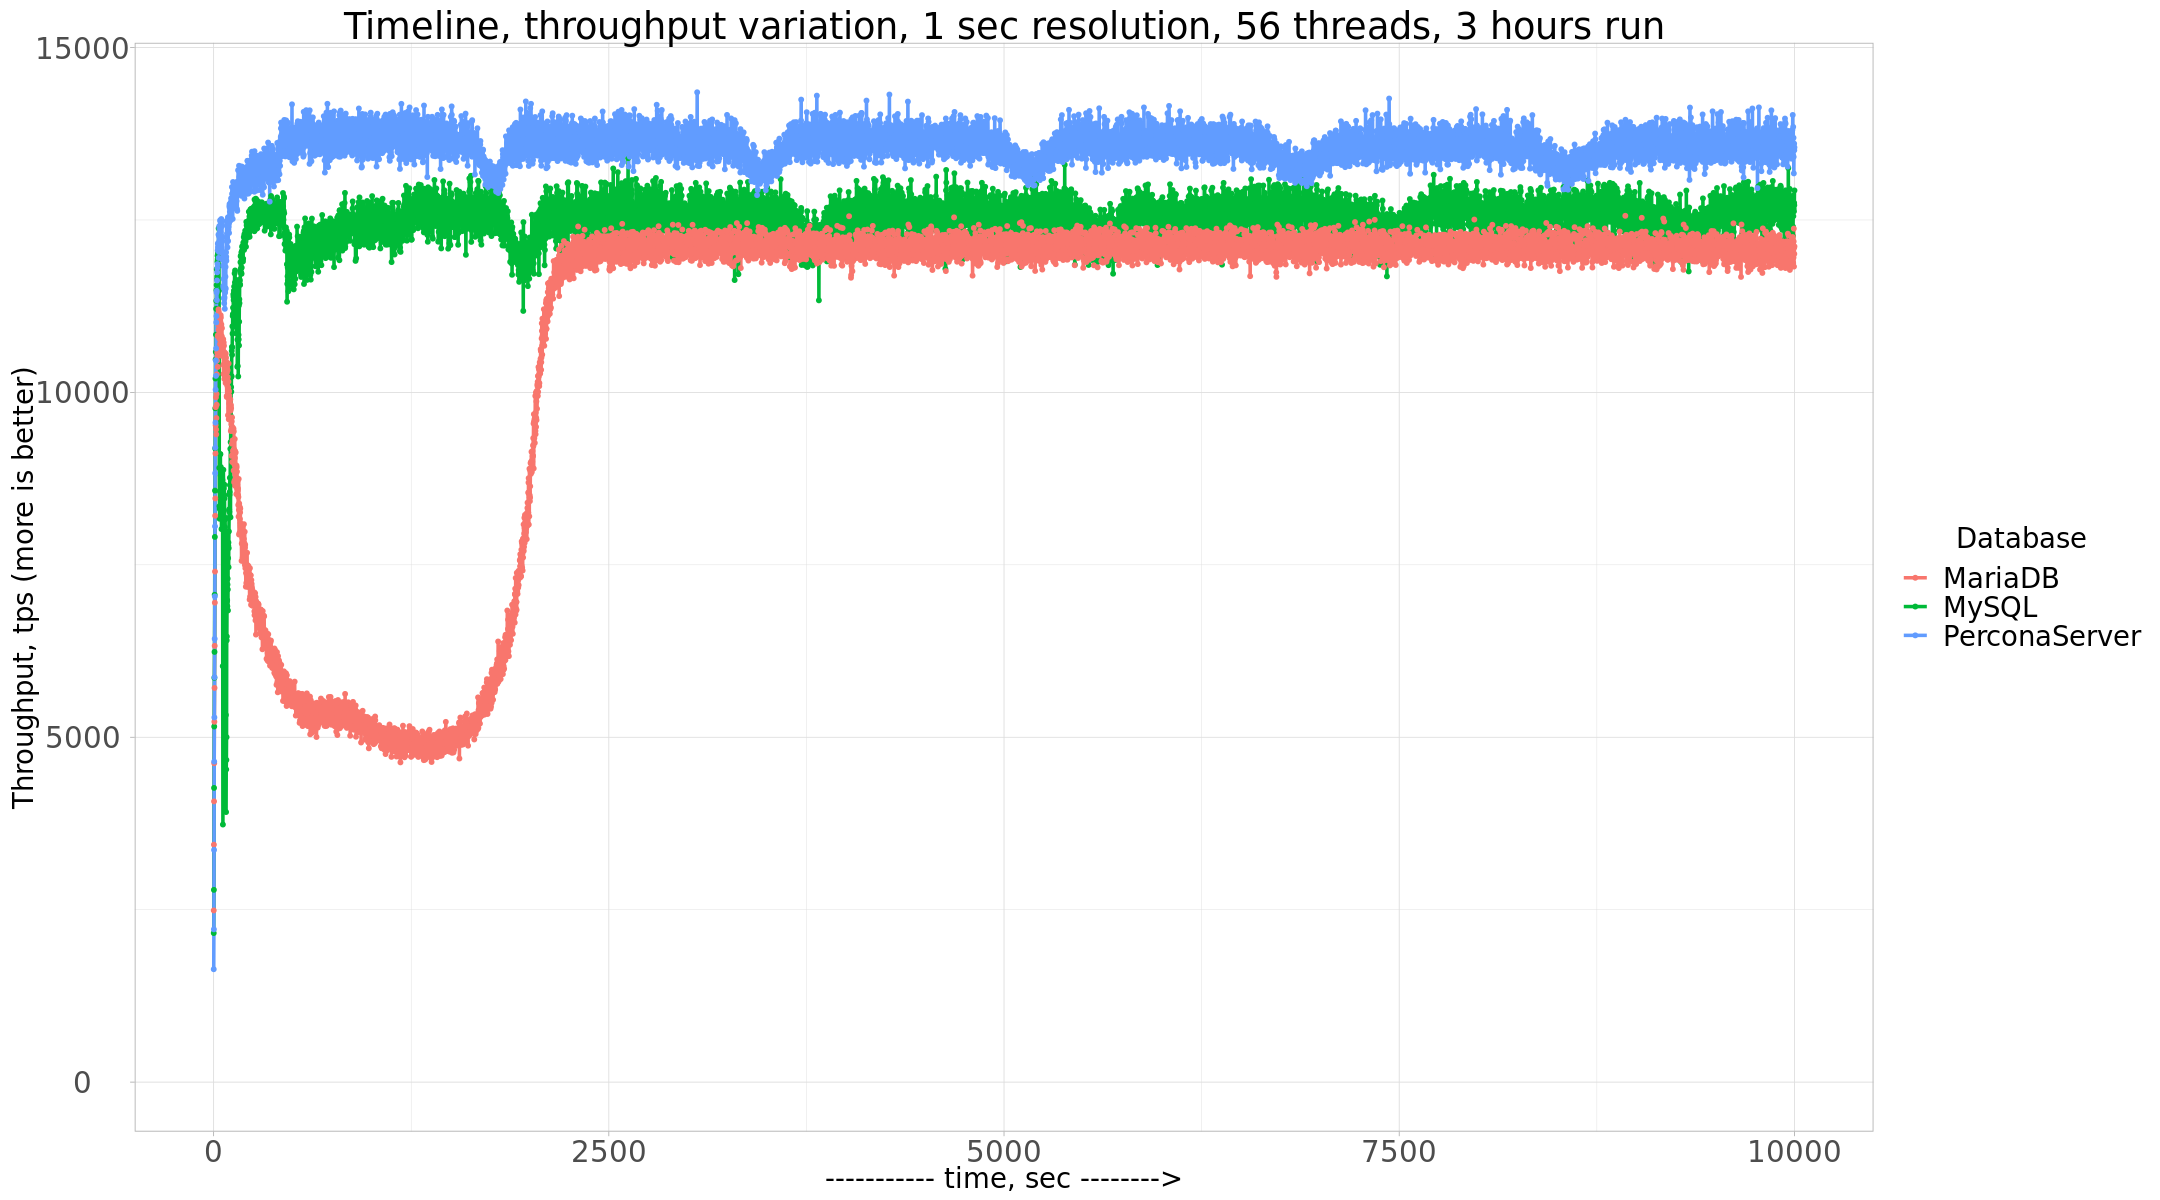

In [22]:
m <- ggplot(data = subset(results), 
            aes(x=V1, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m + geom_line(size=1)+geom_point(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Timeline, throughput variation, 1 sec resolution, 56 threads, 3 hours run")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")
#+
#    facet_grid(WAL ~ .,scales="free")

### Results on individual scales

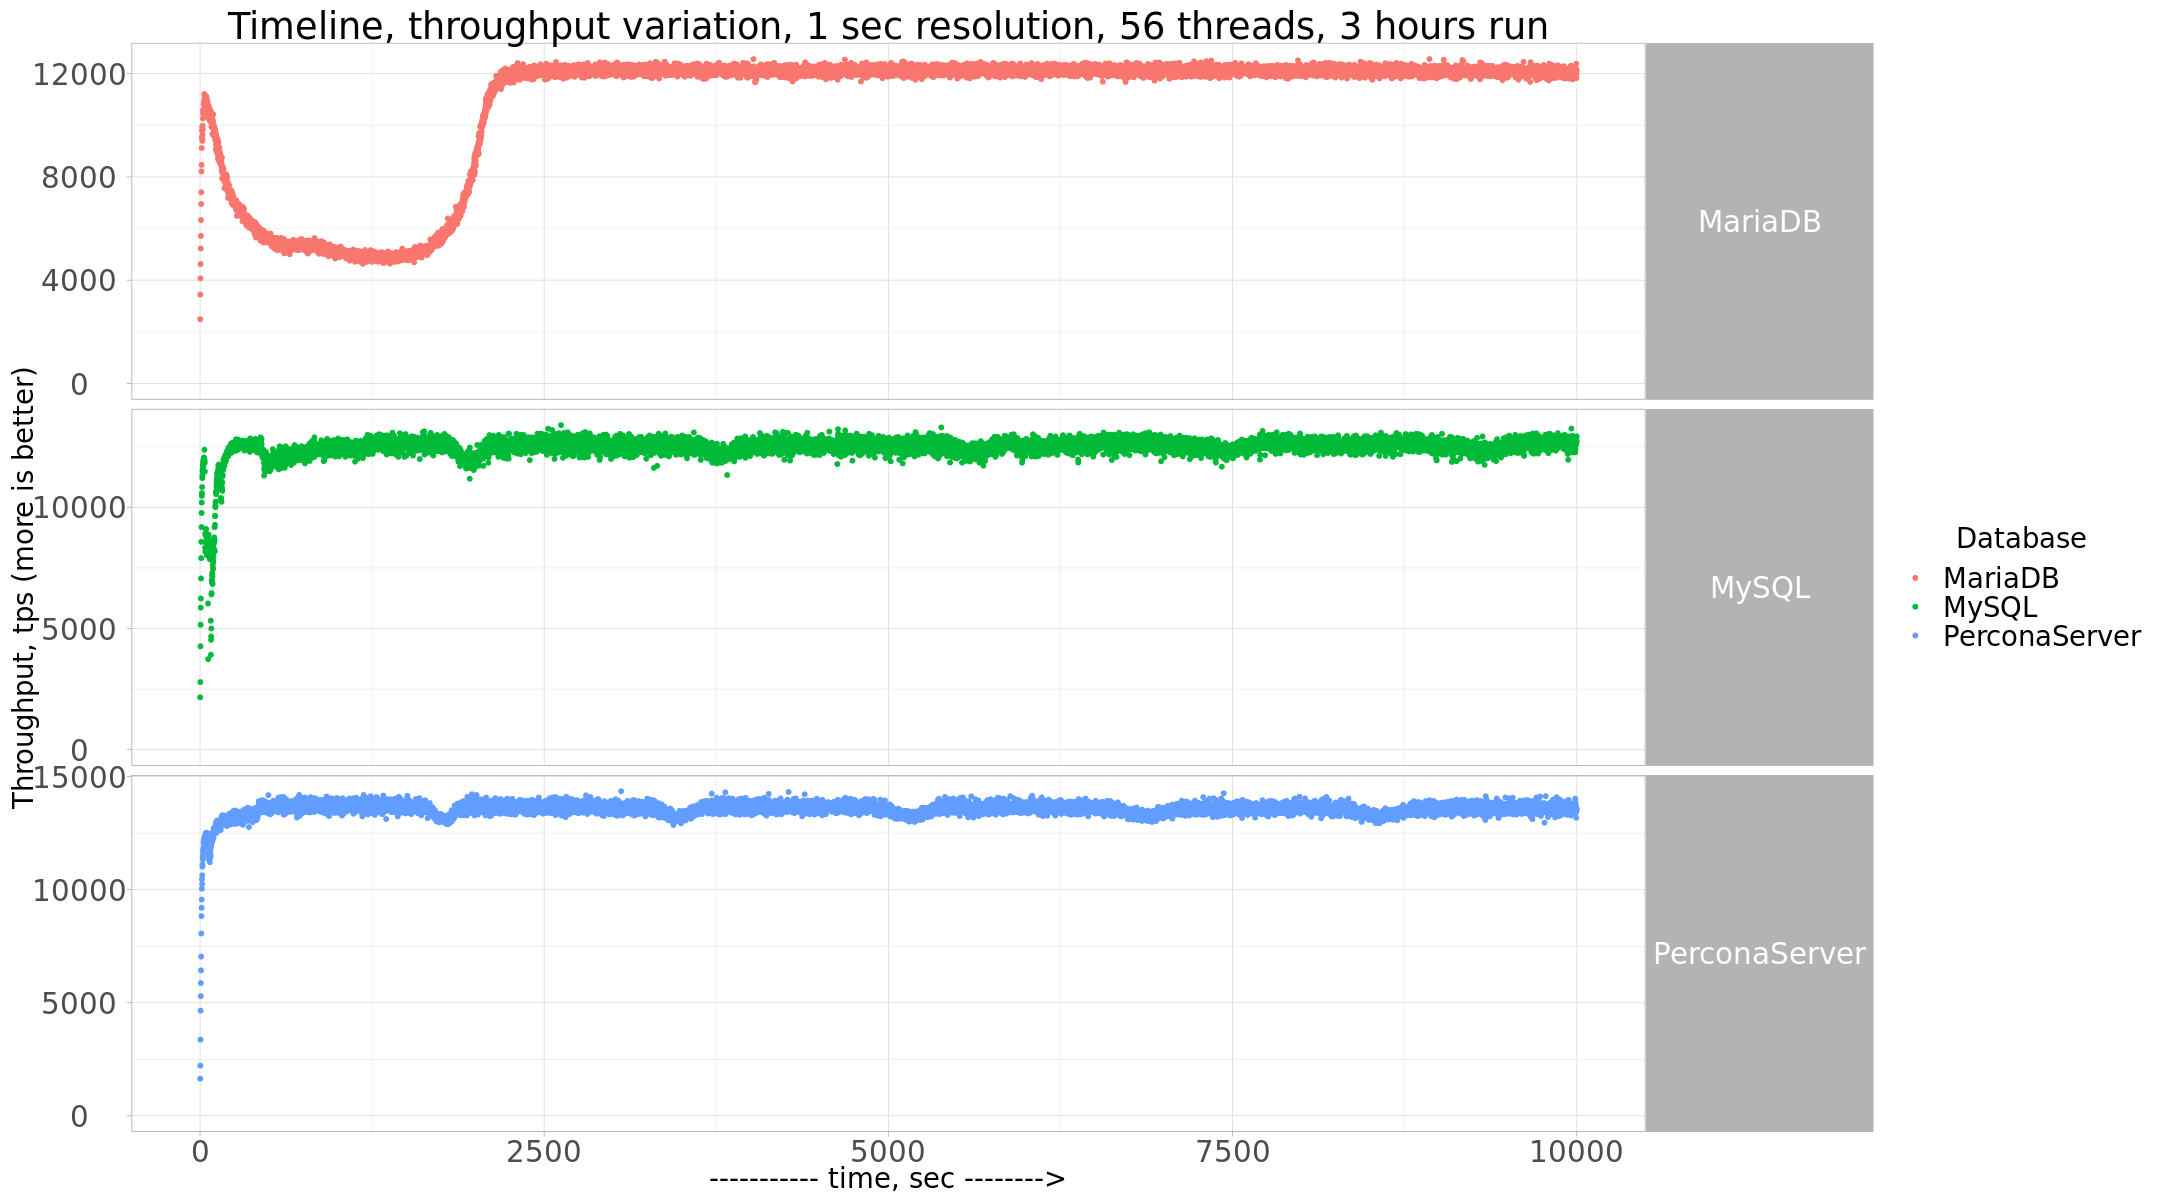

In [23]:
m <- ggplot(data = subset(results), 
            aes(x=V1, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m +geom_point(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Timeline, throughput variation, 1 sec resolution, 56 threads, 3 hours run")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")+
    facet_grid(ver ~ .,scales="free")

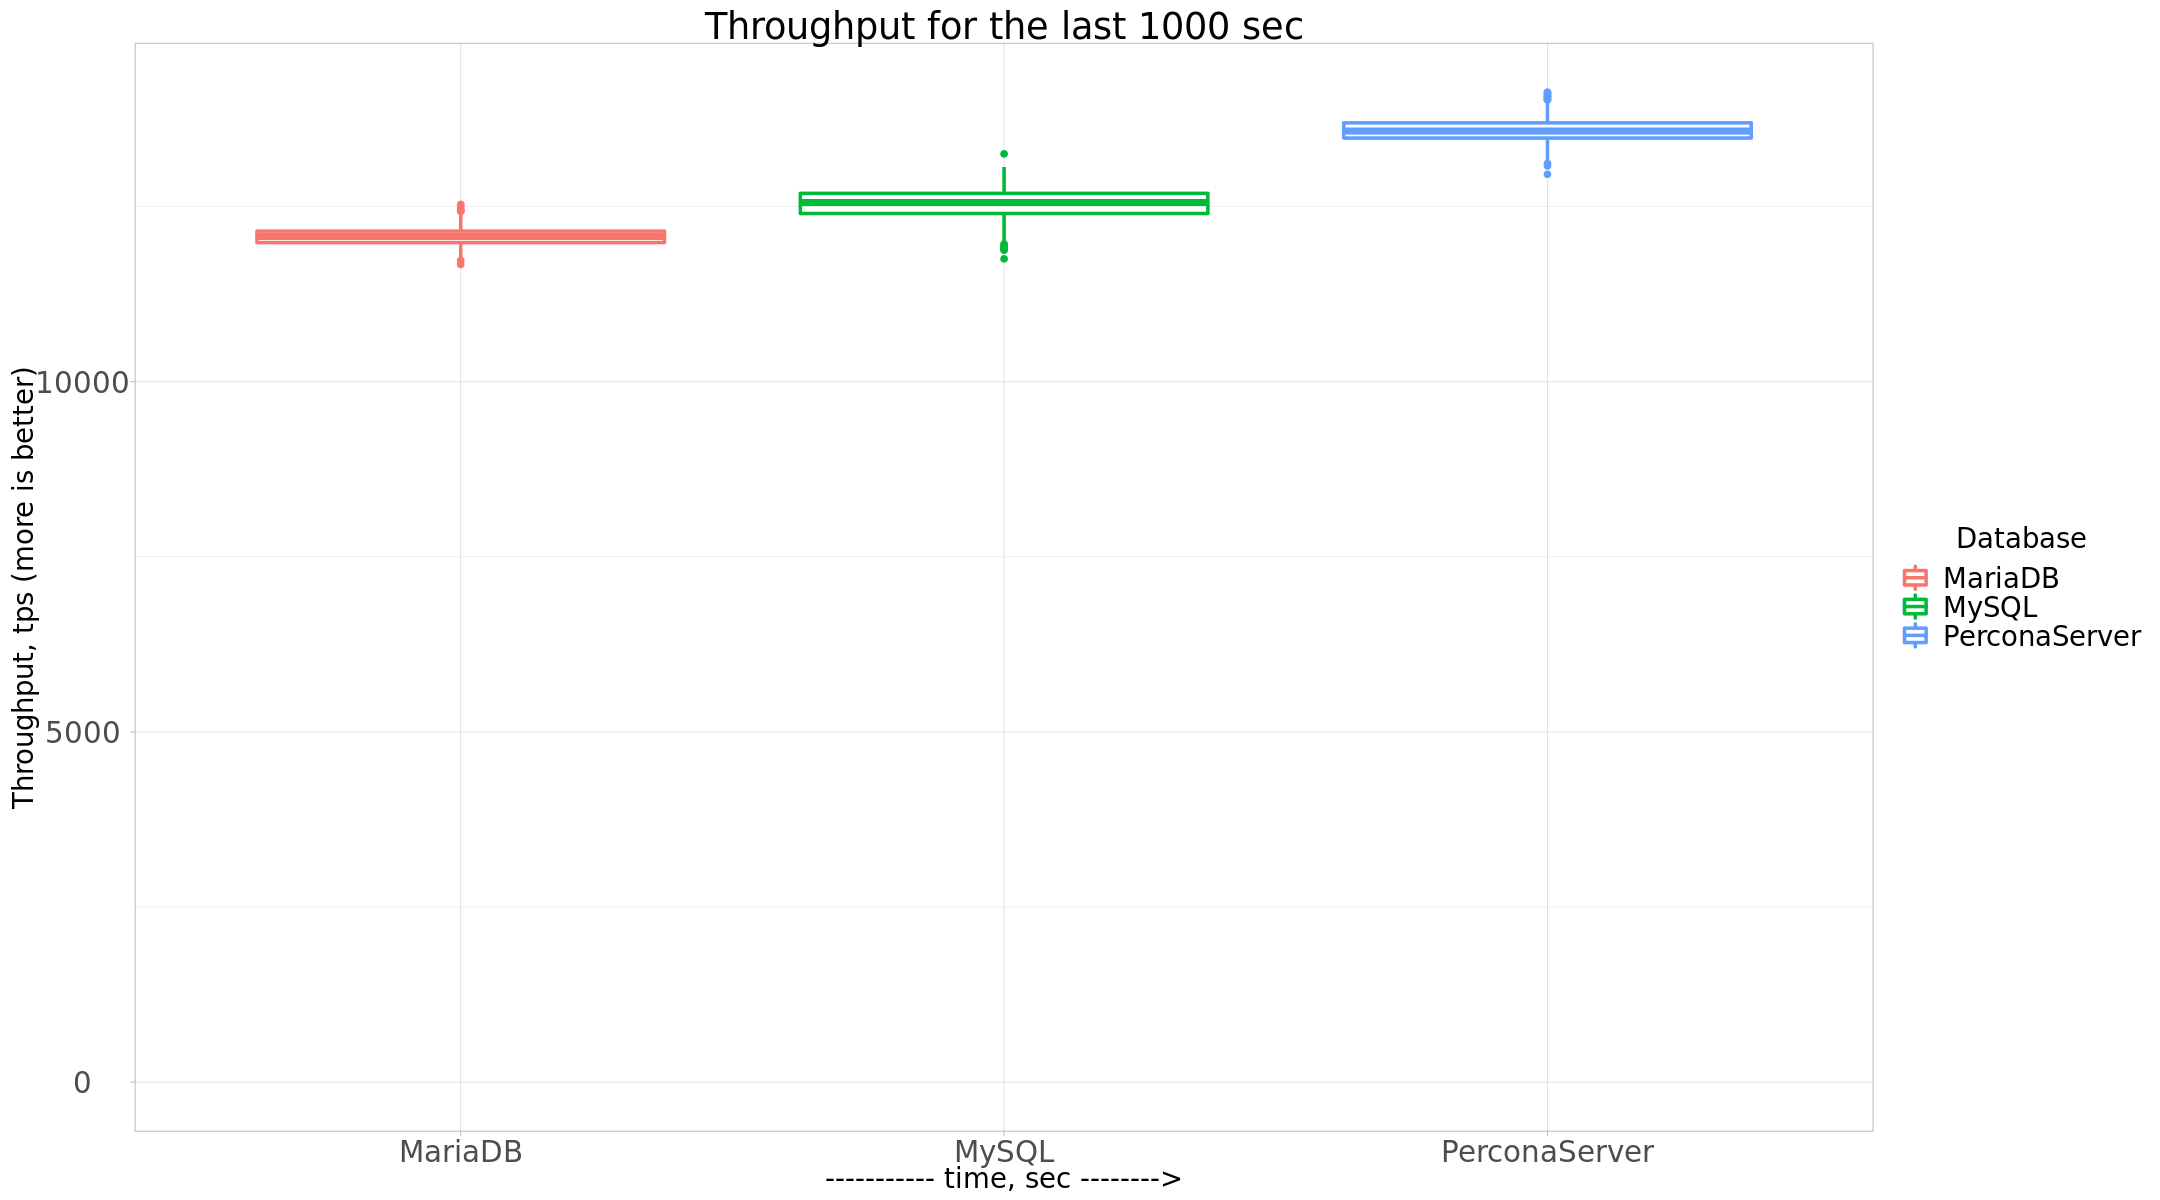

In [24]:
m <- ggplot(data = subset(results,V1>9000), 
            aes(x=ver, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m +geom_boxplot(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Throughput for the last 1000 sec")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")
#+
#    facet_grid(ver ~ .,scales="free")

In [26]:
dmysqlS25<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-19-18-28/mysql-BP25.SSD.io2000/res.thr56txt')
dmariadbS25<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-20-07-28/mariadb-BP25.SSD.io2000/res.thr56txt')
dpsS25<-loadf('https://raw.githubusercontent.com/Percona-Lab-results/2020-07-MySQL-MariaDB-tpcc/master/res-tpcc-8.0.21-2020-07-24-09-04/ps8-BP25.SSD.io2000/res.thr56txt')
dmysqlS25$ver="MySQL"
dmariadbS25$ver="MariaDB"
dpsS25$ver="PerconaServer"

resultsS25<-rbind(dmysqlS25,dmariadbS25,dpsS25)


## Results - SSD Storage, 25GB Buffer pool (IO bound)
Let’s review the results I’ve got.

### Results combined

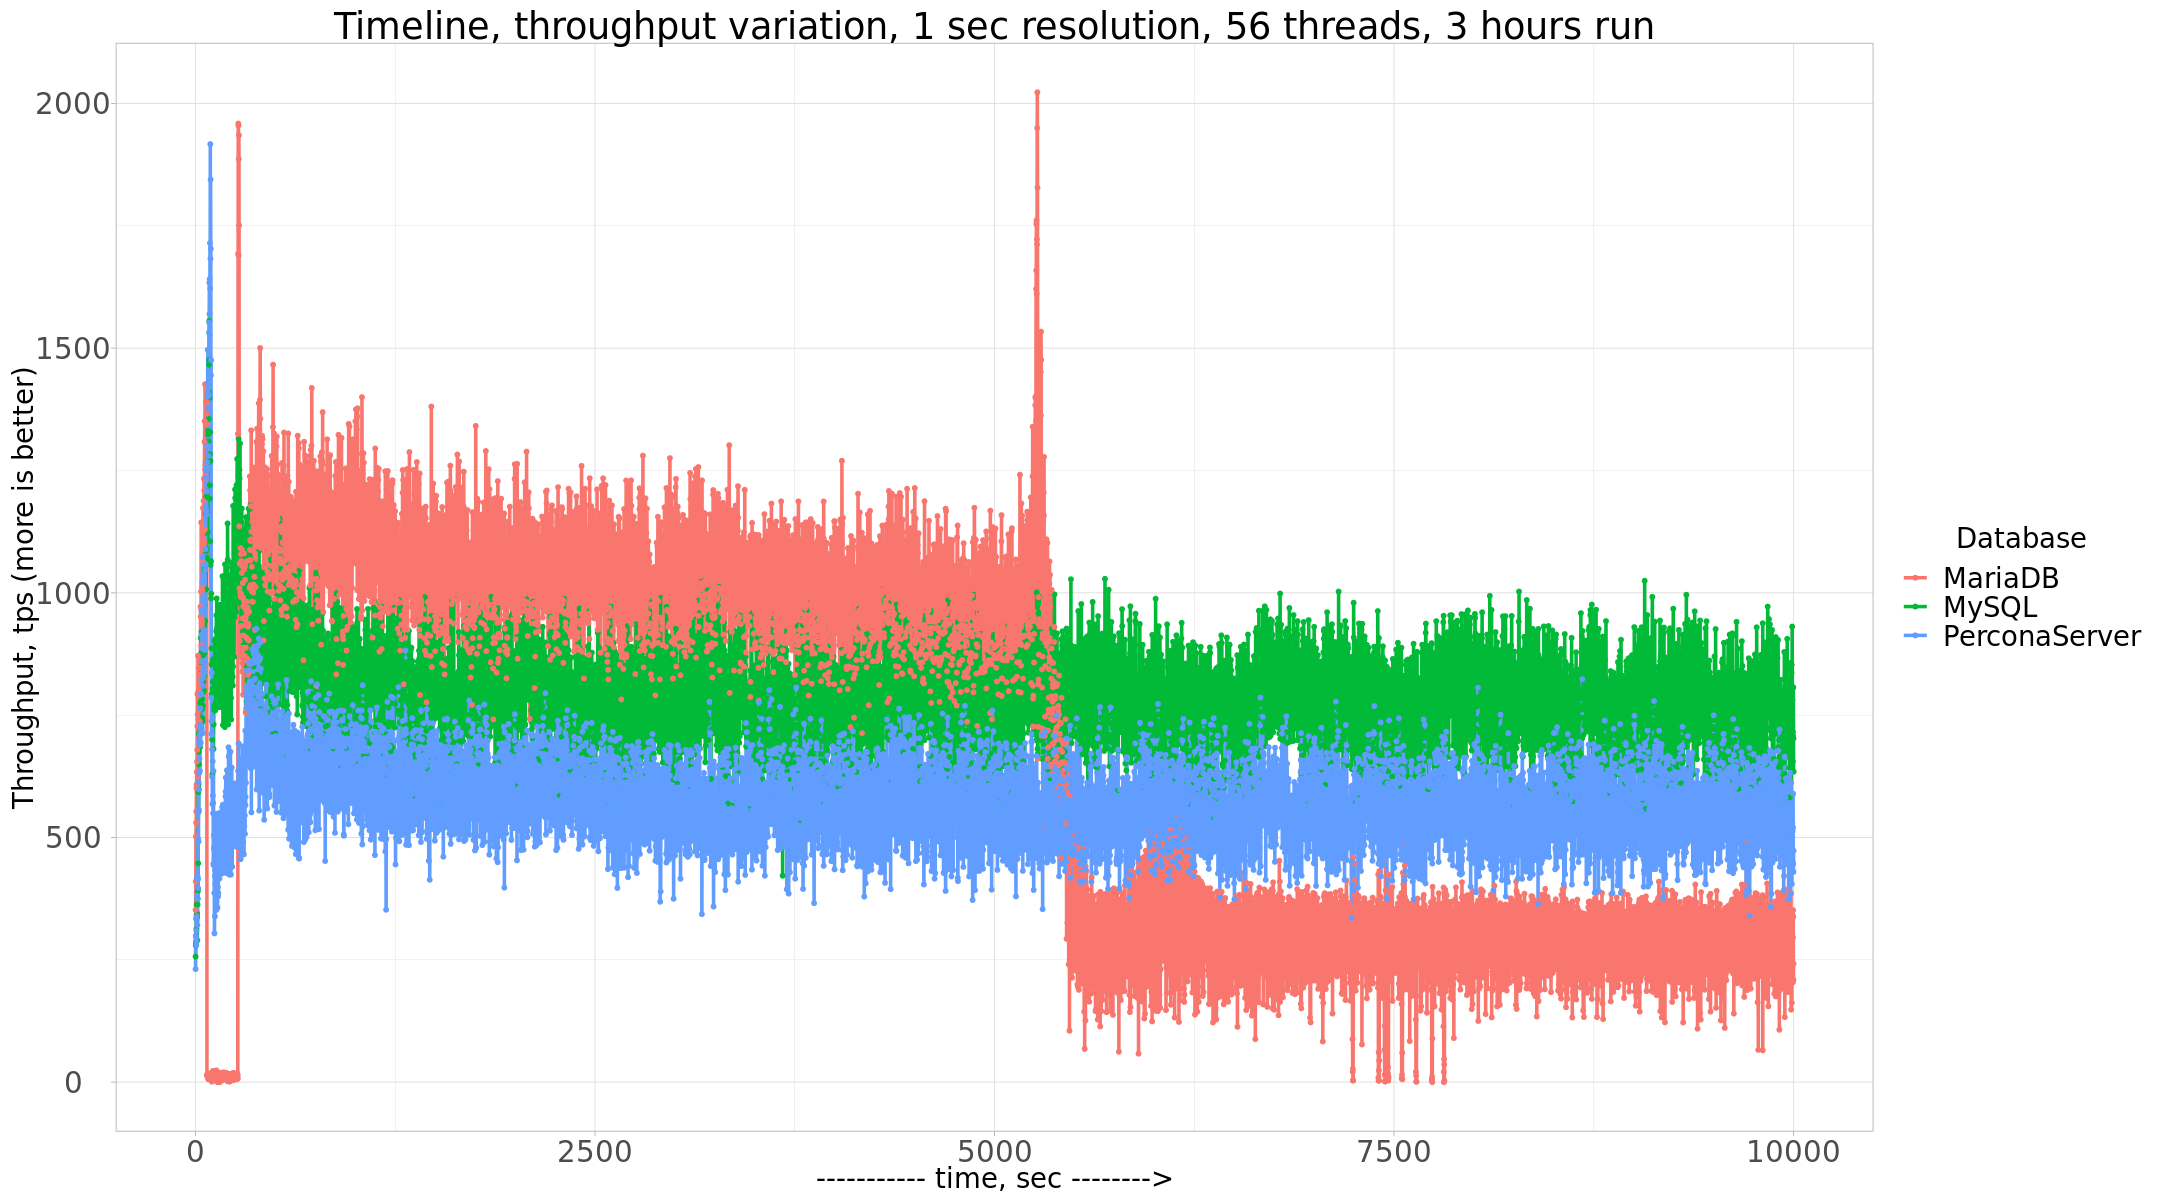

In [27]:
m <- ggplot(data = subset(resultsS25), 
            aes(x=V1, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m + geom_line(size=1)+geom_point(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Timeline, throughput variation, 1 sec resolution, 56 threads, 3 hours run")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")

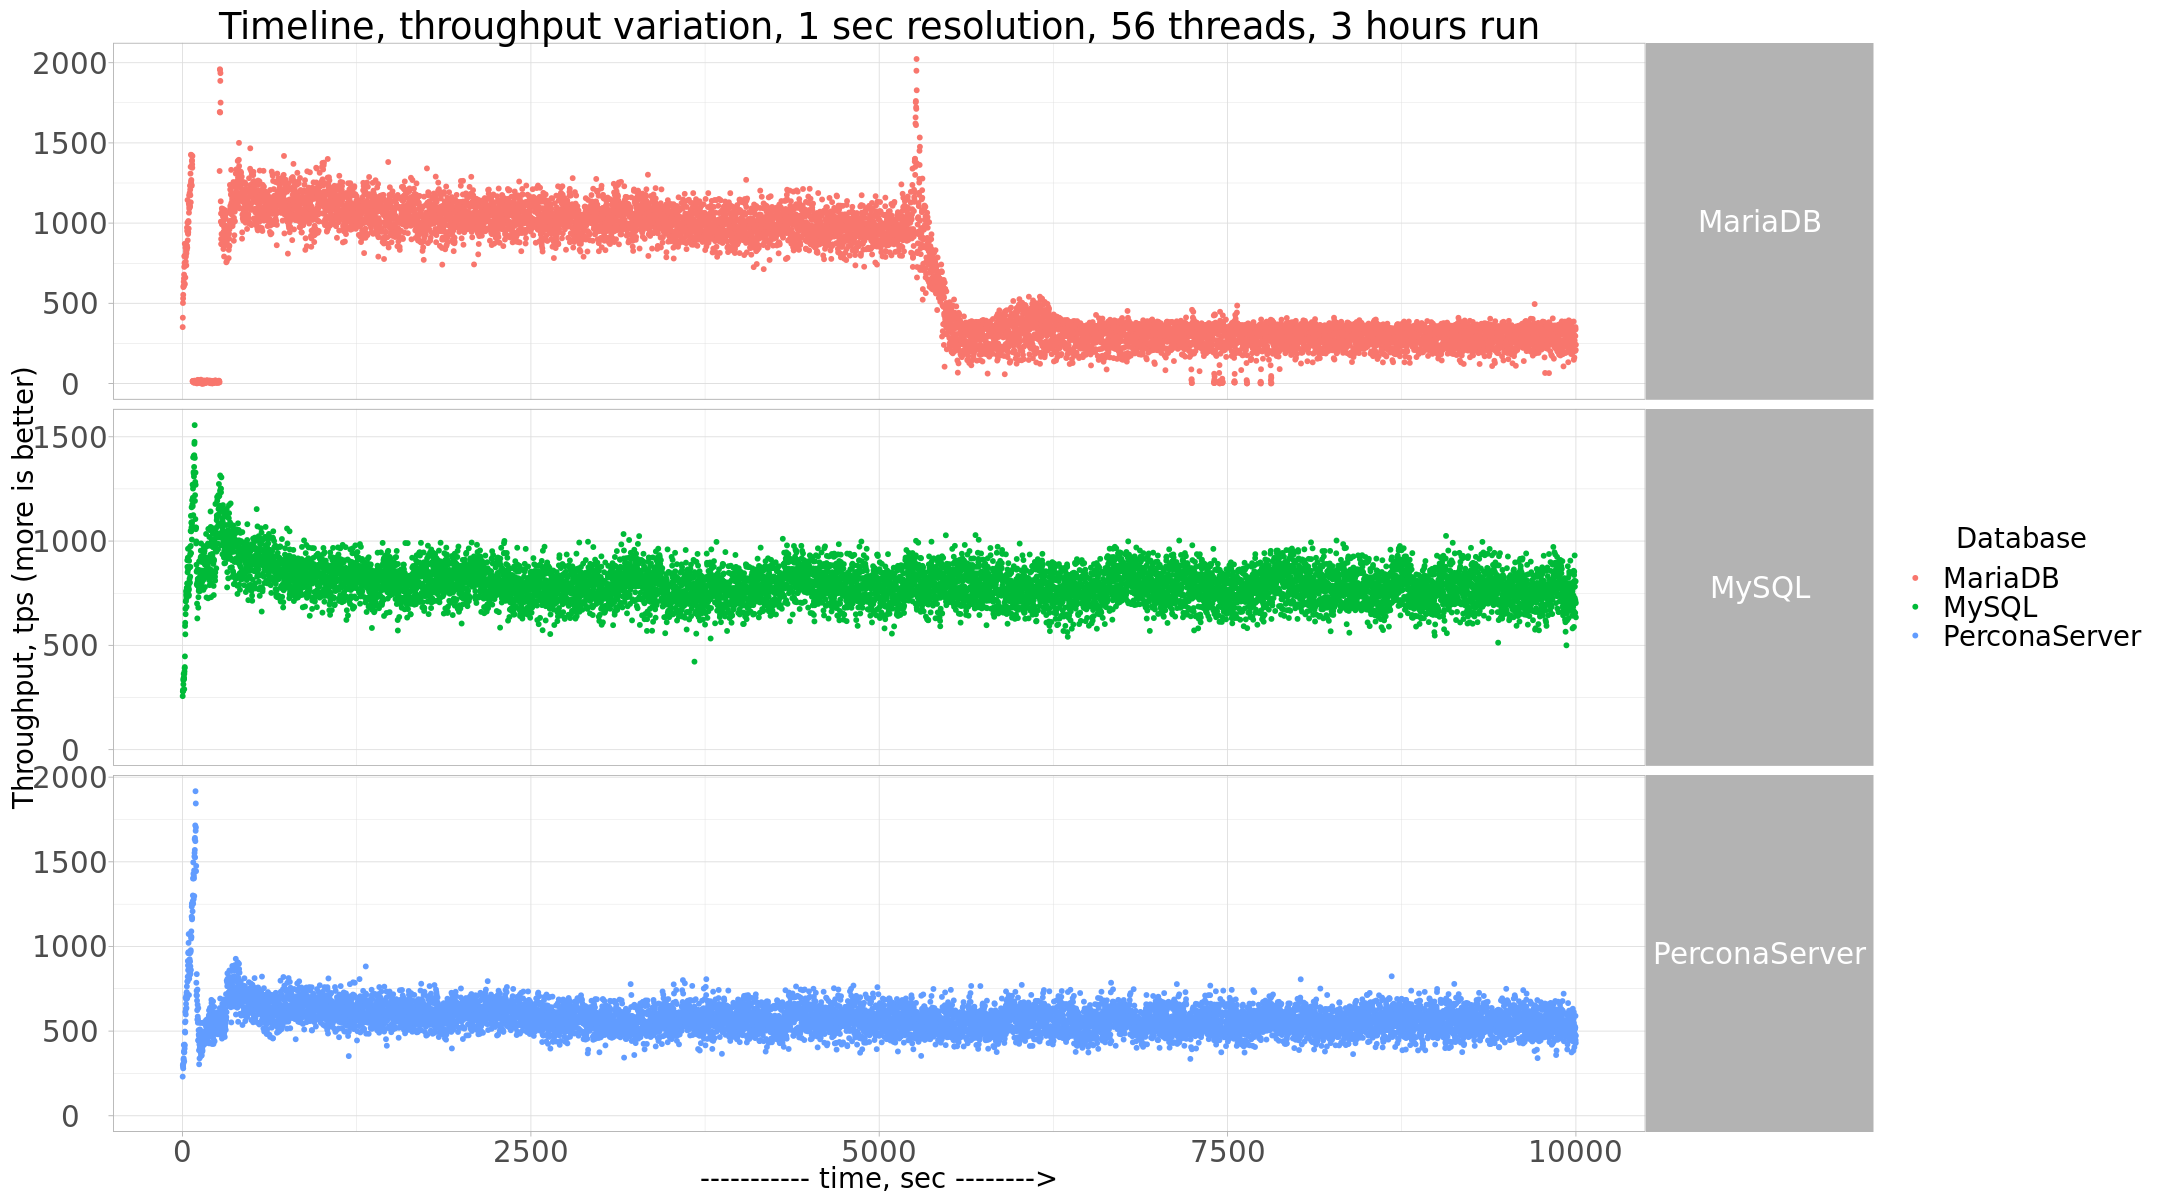

In [28]:
m <- ggplot(data = subset(results), 
            aes(x=V1, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m +geom_point(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Timeline, throughput variation, 1 sec resolution, 56 threads, 3 hours run")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")+
    facet_grid(ver ~ .,scales="free")

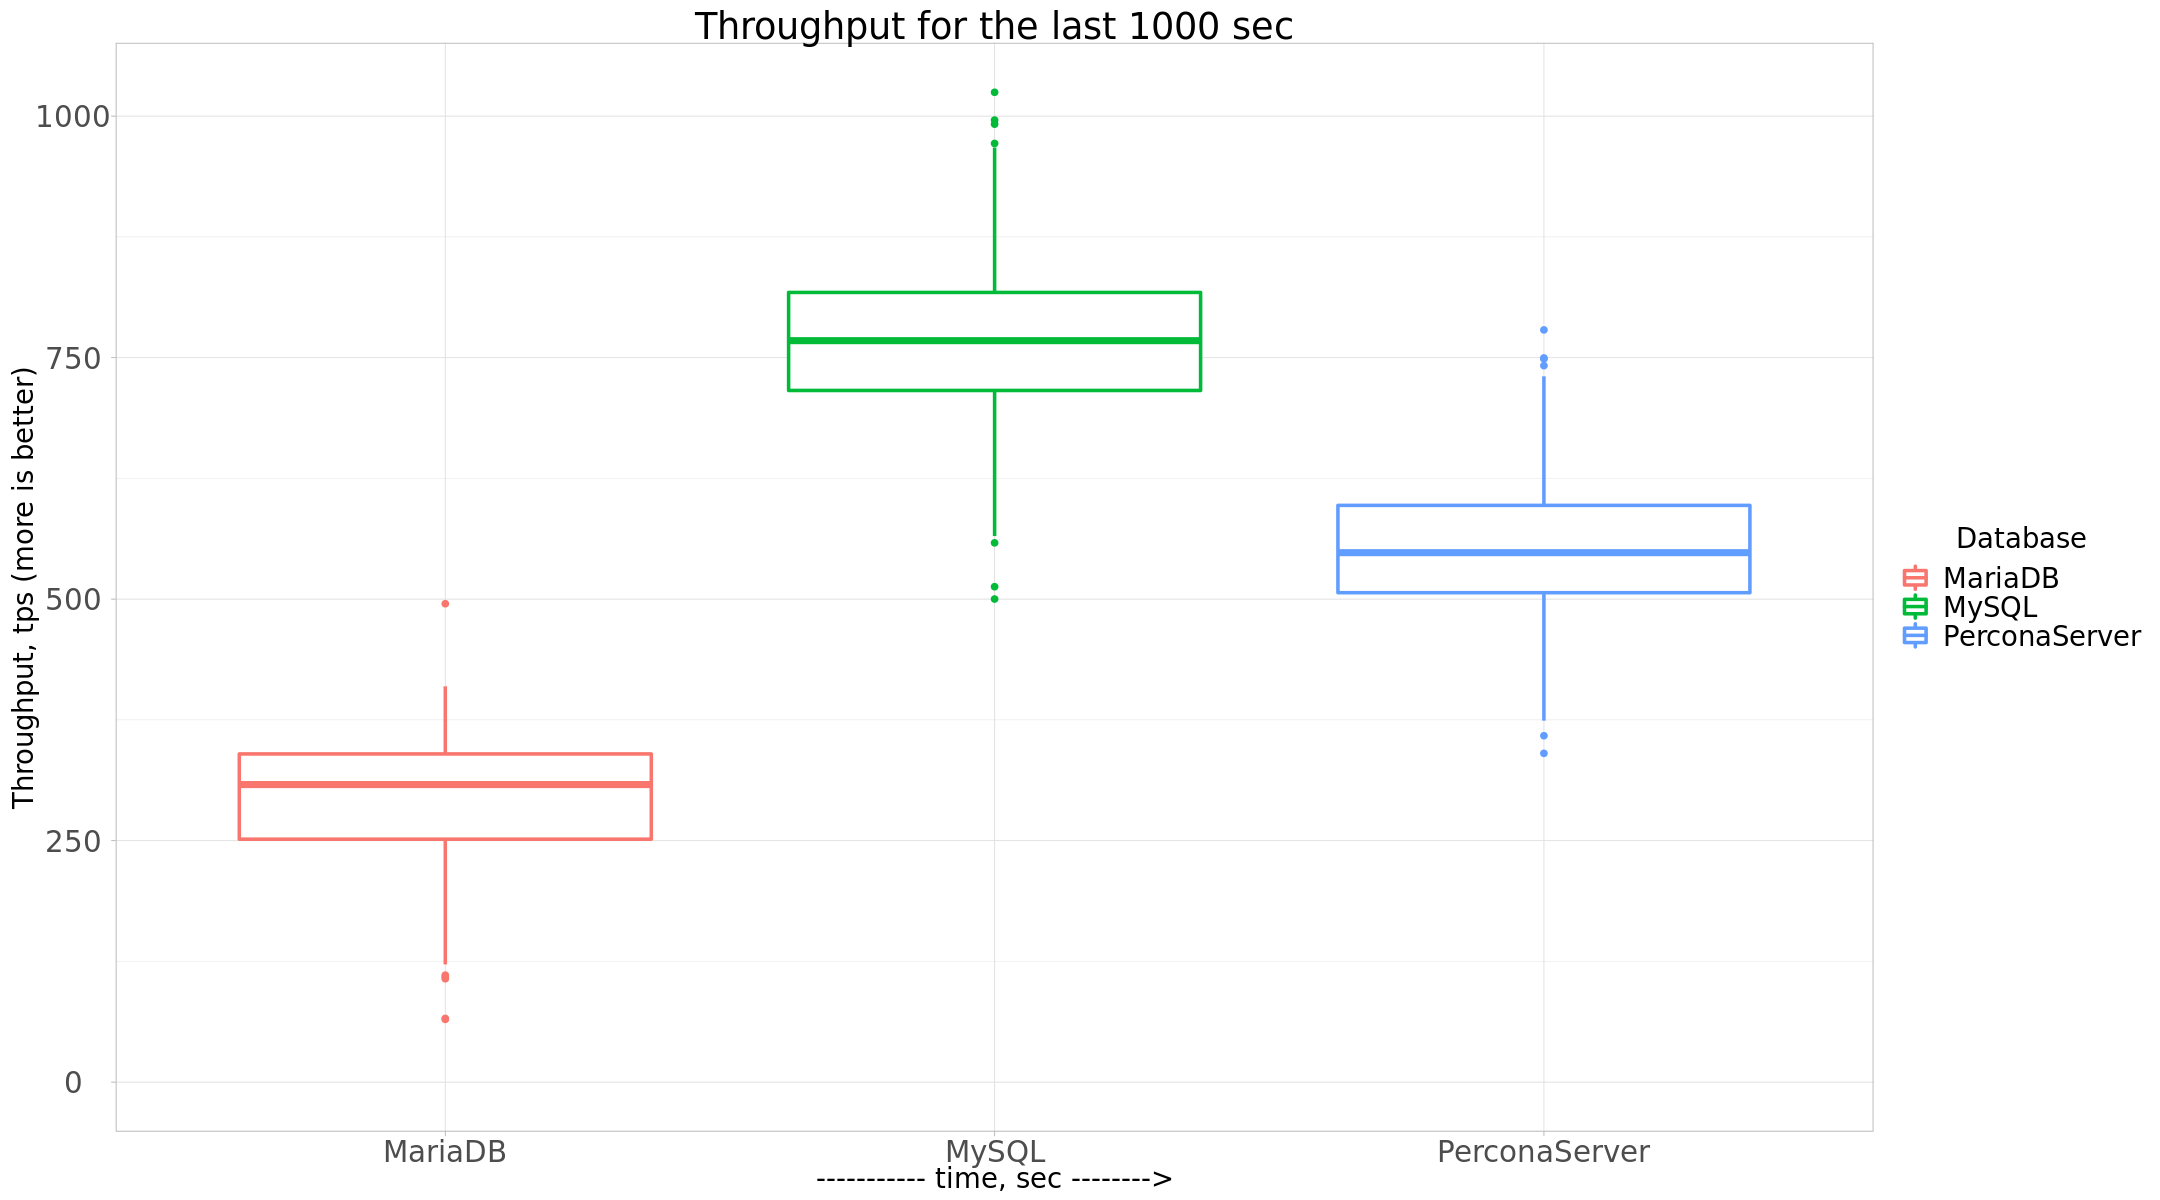

In [29]:
m <- ggplot(data = subset(results,V1>9000), 
            aes(x=ver, y=V3,color=as.factor(ver)))

options(repr.plot.width=18, repr.plot.height=10)


m +geom_boxplot(size=1)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Throughput for the last 1000 sec")+    
    expand_limits(y=0)+
    scale_colour_discrete(name="Database")

# Configs



## MySQL Config
https://github.com/Percona-Lab-results/2020-07-MySQL-MariaDB/blob/master/BP140/mysql/my8.cnf

## MariaDB Config
https://github.com/Percona-Lab-results/2020-07-MySQL-MariaDB/blob/master/BP140/mariadb/mariadb.cnf